### 0. Importación de Librerías

In [1]:
# Librerías fundamentales para computación numérica y manipulación de datos
import numpy as np  # Operaciones vectorizadas y álgebra lineal
import pandas as pd  # Estructuras de datos tabulares (DataFrames)

# Librerías de visualización para gráficos estadísticos
import matplotlib.pyplot as plt  # Gráficos base de bajo nivel
import seaborn as sns  # Gráficos estadísticos de alto nivel
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Módulo de partición de datos y validación cruzada
from sklearn.model_selection import train_test_split

# Módulo de preprocesamiento y transformación de características
from sklearn.preprocessing import StandardScaler

# Técnicas de sobremuestreo para balancear clases
from imblearn.over_sampling import SMOTE

# Modelos de regresión lineal y regularización
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Modelos no paramétricos basados en árboles
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier

# Métricas de evaluación para regresión
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración estética de visualizaciones
sns.set(style="whitegrid")  # Tema visual con grilla de fondo

# Semilla para reproducibilidad de resultados aleatorios
RANDOM_STATE = 42  # Garantiza consistencia en splits y modelos estocásticos

### 1. Data preparation

In [2]:
# 1. CARGA DE DATOS
# Importar datos desde archivo Excel ubicado en Google Drive
df = pd.read_csv(r'data/cleaned_lending_club_2015_2019.csv')  # Ruta relativa al script
df.head()  # Inspeccionar primeras filas para validar importación
# Output: Muestra primeras 5 filas del DataFrame con columnas de variables financieras

,loan_amnt,term,int_rate,home_ownership,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc,is_default
0,14700.0,60,0.1999,1,67000.0,38.15,8.0,665.0,1.0,0.0,30079.0,0.569,37.0,0
1,11200.0,60,0.2099,0,34714.8,25.38,0.0,660.0,1.0,0.0,14486.0,0.792,20.0,1
2,7200.0,36,0.1366,0,32000.0,11.52,0.0,700.0,0.0,0.0,4567.0,0.672,33.0,0
3,10850.0,60,0.1999,0,35000.0,26.41,0.0,675.0,0.0,0.0,20298.0,0.672,42.0,1
4,15000.0,36,0.1199,1,46000.0,8.48,0.0,695.0,1.0,0.0,10550.0,0.748,10.0,0


In [3]:
# TAREA: Cargar datos financieros y preparar pipeline de preprocesamiento

# 1. CARGA DE DATOS
# Importar datos desde archivo Excel ubicado en Google Drive (google drive?)
df = pd.read_csv(r'data/cleaned_lending_club_2015_2019.csv')  # Ruta relativa al script
df.head()  # Inspeccionar primeras filas para validar importación
# Output: Muestra primeras 5 filas del DataFrame con columnas de variables financieras

# 2. SAMPLEO DE DATOS
df = df.sample(n=100000, random_state=RANDOM_STATE).reset_index(drop=True)

# 2. DEFINICIÓN DE VARIABLES PREDICTORAS (X) Y TARGET (y)
# Crear matriz de features excluyendo target y variable temporal
X = df.drop(["int_rate","is_default"], axis=1)  # axis=1 indica eliminación de columnas
# Extraer variable objetivo (tipo de cambio promedio)
y = df["is_default"]  # Serie unidimensional (target)

# 3. SEPARACIÓN DE DATOS EN TRAIN Y TEST
# Dividimos los datos en 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,                          # Datos a dividir
    test_size=0.2,                 # 20% para test
    random_state=RANDOM_STATE,     # Usamos la semilla que definimos al inicio
    stratify=y                     # Mantiene la proporción de defaults en train y test
)

# 3.1 BALANCEO DE CLASES CON SMOTE (solo en train)
# Generamos muestras sintéticas de la clase minoritaria para lograr un 50/50 en el conjunto de entrenamiento
smote = SMOTE(sampling_strategy=1.0, random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 4. NORMALIZACIÓN DE VARIABLES (Z-SCORE SCALING)
# Se calculará la estandirización solamente de la muestra de entrendamiento ya balanceada.
# Instanciar objeto StandardScaler
scaler = StandardScaler()  # Objeto que almacenará μ y σ del conjunto train

# Ajustar scaler con train balanceado y transformar (fit + transform)
X_train = scaler.fit_transform(X_train).copy()  # Calcula μ, σ y transforma
# Transformar test usando parámetros de train (solo transform, NO fit)
X_test = scaler.transform(X_test).copy()  # Aplica misma transformación sin recalcular estadísticas

# Mostramos información de la división y el balance
print("Train:", X_train.shape,                    # Tamaño del conjunto de entrenamiento
      "Test:", X_test.shape,                      # Tamaño del conjunto de prueba
      "Default rate Train (post-SMOTE):", y_train.mean(),  # % de defaults en train balanceado
      "Default rate Test:", y_test.mean())                     # % de defaults en test

Train: (120566, 12) Test: (20000, 12) Default rate Train (post-SMOTE): 0.5 Default rate Test: 0.24645


In [4]:
# Mostrar primeras filas de X_train para verificar normalización
pd.DataFrame(X_train, columns=X.columns).head()

,loan_amnt,term,home_ownership,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc
0,-0.434865,-0.603628,-0.450384,0.658342,-0.766524,-0.350624,0.055248,-0.717913,-0.400327,-0.091572,-0.576299,1.511408
1,-0.850907,-0.603628,2.220330,0.086566,0.355110,-0.350624,0.397075,0.525942,-0.400327,0.580472,-0.147140,1.067978
2,-1.474969,-0.603628,-0.450384,-0.447092,-0.026758,0.866615,0.226161,0.525942,-0.400327,-0.760875,-1.005458,-0.705744
3,3.032148,-0.603628,-0.450384,2.945448,0.026141,-0.350624,-0.457492,-0.717913,1.333418,-0.694151,0.530258,-1.060488
4,0.027403,-0.603628,-0.450384,-0.231088,0.481572,-0.350624,1.422554,-0.717913,-0.400327,0.070411,0.088477,-0.439686


In [5]:
# Mostrar primeras filas de X_train para verificar normalización
pd.DataFrame(X_test, columns=X.columns).head()

,loan_amnt,term,home_ownership,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc
0,1.876477,-0.603628,-0.450384,0.467750,-0.598734,-0.350624,-1.141144,-0.717913,-0.400327,0.773918,0.605992,-0.439686
1,0.004290,-0.603628,-0.450384,0.023671,-0.700400,-0.350624,1.251641,-0.717913,-0.400327,0.066798,-0.647825,1.334036
2,-0.723783,-0.603628,-0.450384,-0.377208,-0.585509,-0.350624,1.764381,-0.717913,-0.400327,-0.363082,-0.294400,-0.617058
3,-0.665999,-0.603628,-0.450384,-0.154851,-0.137517,-0.350624,0.055248,0.525942,-0.400327,0.415436,0.702763,0.269803
4,-0.481092,-0.603628,2.220330,-0.104026,0.194758,4.518329,-0.970231,0.525942,1.333418,-0.741064,-1.358883,2.220897


### 2. Data prediction

In [6]:
# --- ESPECIFICACIÓN Y ENTRENAMIENTO ---

# 1. Definimos la "arquitectura" del modelo (Hiperparámetros)
rf_model = RandomForestClassifier(
    n_estimators=100,       # Usaremos 100 árboles de decisión
    max_depth=10,           # Limitamos la profundidad para evitar memorizar (overfitting)
    min_samples_leaf=5,     # Pedimos grupos mínimos de 5 datos por hoja
    random_state=42,        # Semilla para que los resultados sean reproducibles
    n_jobs=-1               # Usar toda la potencia del procesador
)

# 2. "Aplicamos" el modelo a los datos de entrenamiento
print("Iniciando entrenamiento del modelo...")
rf_model.fit(X_train, y_train) 
print("¡Modelo entrenado exitosamente!")

Iniciando entrenamiento del modelo...
¡Modelo entrenado exitosamente!


In [7]:
# --- DATA PREDICTION (GENERACIÓN DE RESULTADOS) ---

# 1. Predecir Probabilidades
# Esto es lo más rico para el análisis de negocio
probs_default = rf_model.predict_proba(X_test)[:, 1]

# 2. Predecir la Clase Final (Default / No Default)
# Usamos el corte estándar del 50%
preds_finales = rf_model.predict(X_test)

# Mostramos un ejemplo de lo que acabamos de generar
import pandas as pd
ejemplo = pd.DataFrame({
    'Probabilidad_Riesgo': probs_default[:5],
    'Prediccion_Final': preds_finales[:5],
    'Dato_Real': y_test[:5].values
})
print("Primeras 5 predicciones generadas:")
print(ejemplo)

Primeras 5 predicciones generadas:
   Probabilidad_Riesgo  Prediccion_Final  Dato_Real
0             0.295687                 0          1
1             0.156640                 0          0
2             0.167114                 0          0
3             0.403799                 0          0
4             0.329187                 0          0


### 3. Prediction evaluation

In [8]:
# --- EVALUACIÓN DEL MODELO ---
# Métricas generales
print(f"Accuracy (Exactitud): {accuracy_score(y_test, preds_finales):.2%}")
print(f"AUC-ROC (Capacidad de distinción): {roc_auc_score(y_test, probs_default):.2f}")

# Reporte detallado por clase
print("\nReporte de Clasificación:")
print(classification_report(y_test, preds_finales))

Accuracy (Exactitud): 74.43%
AUC-ROC (Capacidad de distinción): 0.66

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.91      0.84     15071
           1       0.47      0.25      0.33      4929

    accuracy                           0.74     20000
   macro avg       0.63      0.58      0.58     20000
weighted avg       0.71      0.74      0.72     20000



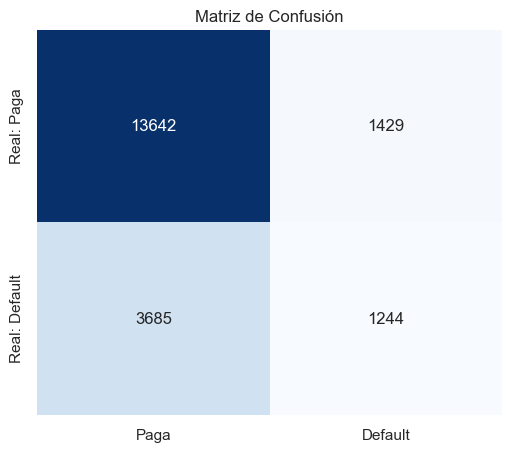

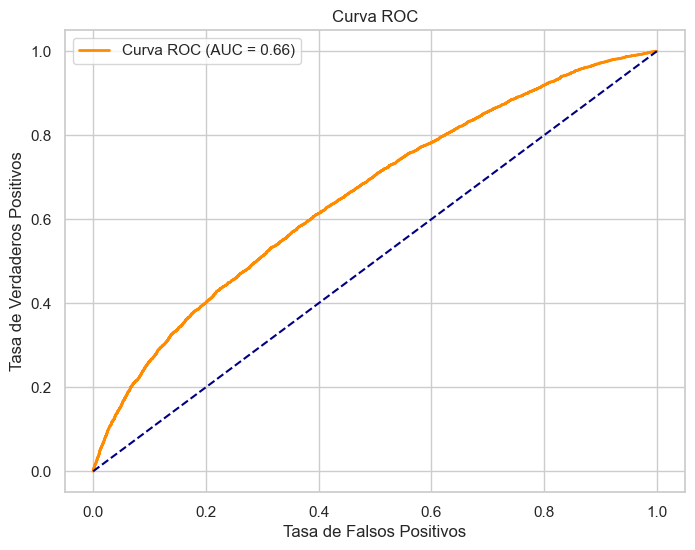

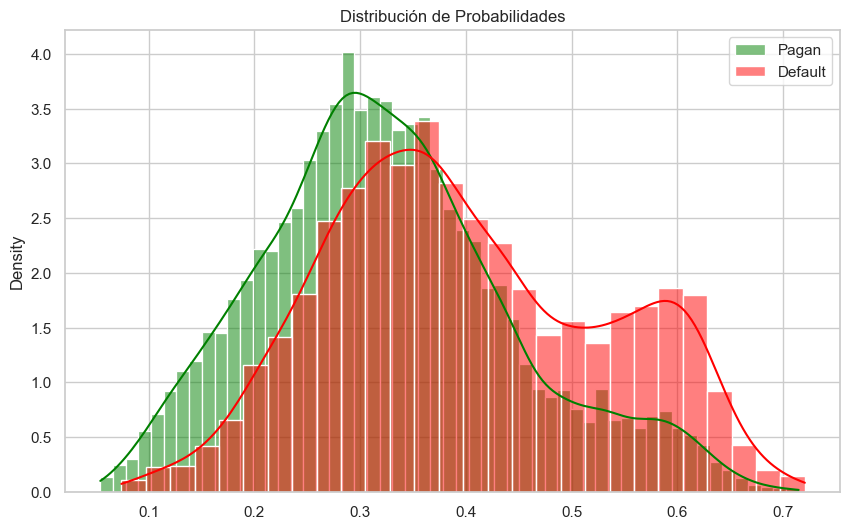

In [9]:
# --- 4. GRÁFICOS DE EVALUACIÓN (ANEXOS) ---

# A) Matriz de Confusión Gráfica
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, preds_finales)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Paga', 'Default'], yticklabels=['Real: Paga', 'Real: Default'])
plt.title('Matriz de Confusión')
plt.show()

# B) Curva ROC
fpr, tpr, _ = roc_curve(y_test, probs_default)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_score(y_test, probs_default):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# C) Histograma de Probabilidades
plt.figure(figsize=(10, 6))
sns.histplot(probs_default[y_test==0], color="green", label="Pagan", kde=True, stat="density", alpha=0.5)
sns.histplot(probs_default[y_test==1], color="red", label="Default", kde=True, stat="density", alpha=0.5)
plt.legend()
plt.title('Distribución de Probabilidades')
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_12336\1950254533.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=feature_importance, palette='viridis')


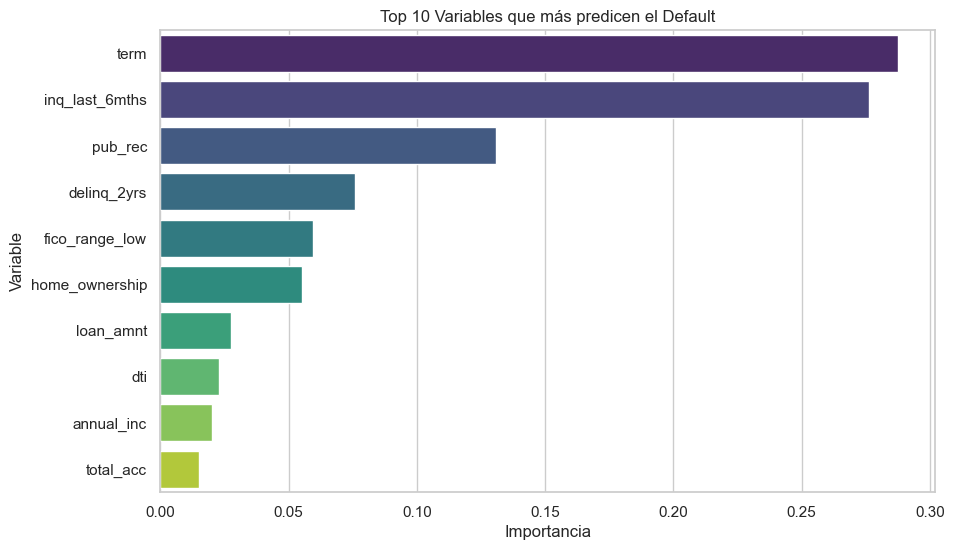

In [10]:
# --- 5. IMPORTANCIA DE VARIABLES ---
feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=feature_importance, palette='viridis')
plt.title('Top 10 Variables que más predicen el Default')
plt.show()

In [11]:
# --- CHEQUEO DE OVERFITTING (Estabilidad del Modelo) ---
# Predecimos sobre los datos de entrenamiento para comparar
y_train_pred = rf_model.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, preds_finales)

print(f"Accuracy en Entrenamiento (Train): {train_acc:.2%}")
print(f"Accuracy en Prueba (Test):       {test_acc:.2%}")

diferencia = train_acc - test_acc
if diferencia > 0.10:
    print(f"⚠️ ALERTA: Hay signos de Overfitting. La diferencia es {diferencia:.1%}")
else:
    print(f"✅ ESTABLE: El modelo generaliza bien. La diferencia es solo {diferencia:.1%}")

Accuracy en Entrenamiento (Train): 79.47%
Accuracy en Prueba (Test):       74.43%
✅ ESTABLE: El modelo generaliza bien. La diferencia es solo 5.0%


In [12]:
# Generación de archivo comparativo
# 1. Aseguramos que los datos tengan el formato correcto (Arrays de Numpy)
# Usamos .values si es una Serie de Pandas para evitar errores de índices desordenados
realidad = y_test.values if hasattr(y_test, 'values') else y_test

# 2. Creamos la tabla con las 3 columnas clave
df_comparacion = pd.DataFrame({
    'Realidad_Default': realidad,          # 0 = Pagó, 1 = Default
    'Probabilidad_Estimada': probs_default, # Valor entre 0 y 1 (ej. 0.85)
    'Prediccion_Modelo': preds_finales      # Decisión final (0 o 1)
})

# 3. Exportamos al archivo CSV
nombre_archivo = 'Resultados_vs_Realidad.csv'
df_comparacion.to_csv(nombre_archivo, index=False)

print(f"✅ ¡Archivo '{nombre_archivo}' generado exitosamente!")
print(f"Total de clientes comparados: {len(df_comparacion)}")
print("\n--- Vista previa de los primeros 5 casos ---")
print(df_comparacion.head())

✅ ¡Archivo 'Resultados_vs_Realidad.csv' generado exitosamente!
Total de clientes comparados: 20000

--- Vista previa de los primeros 5 casos ---
   Realidad_Default  Probabilidad_Estimada  Prediccion_Modelo
0                 1               0.295687                  0
1                 0               0.156640                  0
2                 0               0.167114                  0
3                 0               0.403799                  0
4                 0               0.329187                  0
